In [33]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.metrics import classification_report

In [34]:
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 30
DATA_DIR = "/home/deeptanshu/Desktop/soil-classification/soil-classification-part-2/soil_competition-2025"  
SEED = 42  

In [35]:
df = pd.read_csv(os.path.join(DATA_DIR, 'train_labels.csv'))
df = df[df['label'] == 1]

In [36]:
def load_images(image_ids, image_dir):
    images = []
    for img_id in image_ids:
        path = os.path.join(image_dir, img_id)
        img = Image.open(path).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
        img = img_to_array(img) / 255.0
        images.append(img)
    return np.array(images)

images = load_images(df['image_id'], os.path.join(DATA_DIR, 'train'))

In [37]:
x_train, x_val = train_test_split(images, test_size=0.2, random_state=SEED)

In [38]:
def build_autoencoder():
    input_img = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2,2), padding='same')(x)
    x = layers.Conv2D(16, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2), padding='same')(x)
    
    x = layers.Conv2D(8, (3,3), activation='relu', padding='same')(x)
    
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(16, (3,3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
    decoded = layers.Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)
    
    model = models.Model(input_img, decoded)
    model.compile(optimizer='adam', loss='mse')
    return model

autoencoder = build_autoencoder()
autoencoder.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 64, 64, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 32, 32, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_6 (UpSampling2D)  │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 64, 64, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_7 (UpSampling2D)  │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 128, 128, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,355 (52.17 KB)

 Trainable params: 13,355 (52.17 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
history=autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=BATCH_SIZE,
                validation_data=(x_val, x_val))

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 313ms/step - loss: 0.0635 - val_loss: 0.0271
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 306ms/step - loss: 0.0214 - val_loss: 0.0113
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 307ms/step - loss: 0.0100 - val_loss: 0.0091
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 313ms/step - loss: 0.0085 - val_loss: 0.0118
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 336ms/step - loss: 0.0087 - val_loss: 0.0077
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 325ms/step - loss: 0.0068 - val_loss: 0.0072
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 325ms/step - loss: 0.0067 - val_loss: 0.0068
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 325ms/step - loss: 0.0064 - val_loss: 0.0066
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 314ms/step - loss: 0.0061 - val_loss: 0.0065
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 314ms/step - loss: 0.0061 - val_loss: 0.0064
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 308ms/step - loss: 0.0058 - val_loss: 0.0063
Epoch 12/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s

In [40]:
val_df = df.sample(frac=0.2, random_state=SEED)
val_imgs = load_images(val_df['image_id'], os.path.join(DATA_DIR, 'train'))
val_labels = val_df['label'].values

In [41]:
recons = autoencoder.predict(val_imgs)
errors = np.mean(np.square(val_imgs - recons), axis=(1,2,3))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


In [42]:
threshold = np.percentile(errors[val_labels == 1], 95) 

In [43]:
val_preds = (errors > threshold).astype(int)

print(classification_report(val_labels, val_preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.05      0.10       244

    accuracy                           0.05       244
   macro avg       0.50      0.03      0.05       244
weighted avg       1.00      0.05      0.10       244



/home/deeptanshu/Desktop/soil-classification/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/deeptanshu/Desktop/soil-classification/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/deeptanshu/Desktop/soil-classification/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [44]:
test_df = pd.read_csv(os.path.join(DATA_DIR, 'test_ids.csv'))
p_anomaly = np.mean(val_preds)

In [45]:
submission_preds = np.random.binomial(n=1, p=p_anomaly, size=len(test_df))

submission = pd.DataFrame({
    'image_id': test_df['image_id'],
    'label': submission_preds
})

submission.to_csv('submission1.csv', index=False)
print("submission.csv created")

submission.csv created


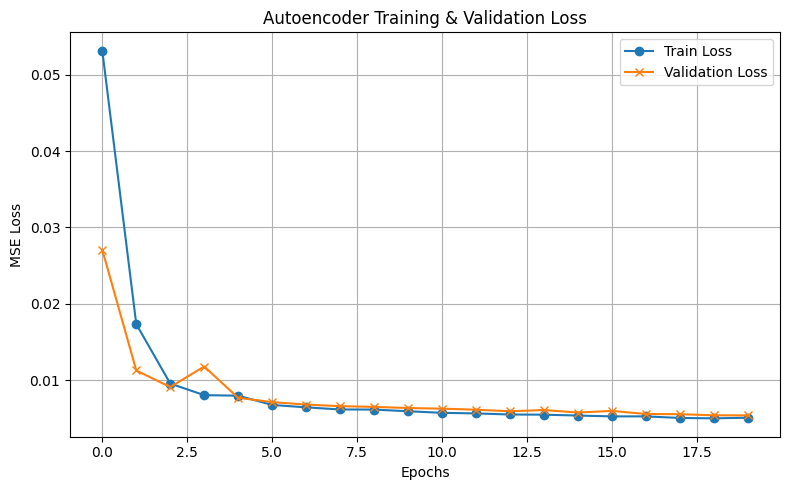

In [46]:
import matplotlib.pyplot as plt

# Plot loss curves
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='x')
plt.title("Autoencoder Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
